In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np    

from scipy.stats import chi2_contingency 
from lightgbm import  LGBMClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline

from preprocess import separate, extra_features
from pipelines import pipe, pipe2

In [2]:
def chi(data):
    col_drop=[]
    
    for col in data.columns:
        
        ct=pd.crosstab(y, data[col])
        chi2, p, _, _ =chi2_contingency(ct)
        
        if p >= 0.05:
            col_drop.append(col)
        elif chi2 <= 1000:
            col_drop.append(col)
            
    return col_drop

In [3]:
train = pd.read_csv("Datasets/train.csv") 
X = train.drop('cost_category', axis=1)
y = train['cost_category']
col_drop = chi(train)
X.drop(columns = col_drop, inplace=True)
print(f"X: {X.shape}\ny: {y.shape}")

X: (18506, 19)
y: (18506,)


In [4]:
col_drop

['Tour_ID']

In [5]:
X1 = pipe(X)
X2 = pipe2(X)
print(f"X1: {X1.shape}\nX2: {X2.shape}")

X1: (18506, 57)
X2: (18506, 147)


In [6]:
le = LabelEncoder()
y = le.fit_transform(y)
y.shape

(18506,)

In [8]:
models= { 
    "KNN": KNeighborsClassifier(n_neighbors=3), 
    "LSVC" : LinearSVC(C=0.1, max_iter=10000, dual=False, multi_class='ovr'),
    "SGD": SGDClassifier(max_iter=10000, learning_rate='optimal', loss='log_loss'),
    "LGR": LogisticRegression(multi_class='ovr',penalty='l2',
                              max_iter=10000, C=0.1, solver='lbfgs'),
    "LGBM": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=6), 
    "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.1, max_depth=6, logging_level='Silent'),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6),
    "Forest": RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=8),
    "Tree": DecisionTreeClassifier(criterion='gini', max_depth=8),
}


samples={
    "X1": X1,
    "X2": X2,
}

In [9]:
kfolds=StratifiedKFold(n_splits=10,shuffle=True)

def strat(clf, sample, y, kfold):

    results= {}

    results['model_name'] = clf + "_" + sample
    
    
    model = models[clf]
    X = samples[sample]
    
    for fold, (train_idx, val_idx) in enumerate(kfolds.split(X,y)):
        X_train, X_test = X[train_idx], X[val_idx]
        y_train, y_test = y[train_idx], y[val_idx]
    
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        
        if model != models['LSVC']:
            predictions = model.predict_proba(X_test)
            
            results["ROC_AUC_{}".format(fold+1)] = roc_auc_score(y_test, predictions, multi_class='ovr')
            
        results["F1_Fold_{}".format(fold+1)] = f1_score(y_test,y_pred , average='weighted')
        results["PRE_Fold_{}".format(fold+1)] = precision_score(y_test,y_pred ,zero_division=0, average='weighted')
        results["REC_Fold_{}".format(fold+1)] = recall_score(y_test,y_pred , zero_division=0, average='weighted')
        
    #df= pd.DataFrame(results)   
    return results

In [10]:
all_models=[]

for model in models:
    for X in samples:
        all_models.append(strat(model, X, y, kfolds))
        print(f"Model: { model }_{X}...........\n")

Model: KNN_X1...........

Model: KNN_X2...........

Model: LSVC_X1...........

Model: LSVC_X2...........

Model: SGD_X1...........

Model: SGD_X2...........

Model: LGR_X1...........

Model: LGR_X2...........

Model: LGBM_X1...........

Model: LGBM_X2...........

Model: CatBoost_X1...........

Model: CatBoost_X2...........

Model: XGBoost_X1...........

Model: XGBoost_X2...........

Model: Forest_X1...........

Model: Forest_X2...........

Model: Tree_X1...........

Model: Tree_X2...........



In [12]:
models_df=pd.DataFrame(all_models)

#models_df.dropna(axis=1, inplace=True)
F1 = ['F1_Fold_1','F1_Fold_2','F1_Fold_3','F1_Fold_4','F1_Fold_5',
     'F1_Fold_6', 'F1_Fold_7','F1_Fold_8','F1_Fold_9','F1_Fold_10']

Rec = ['REC_Fold_1','REC_Fold_2','REC_Fold_3','REC_Fold_4','REC_Fold_5',
       'REC_Fold_6', 'REC_Fold_7','REC_Fold_8','REC_Fold_9','REC_Fold_10']

Pre = ['PRE_Fold_1','PRE_Fold_2','PRE_Fold_3','PRE_Fold_4','PRE_Fold_5',
       'PRE_Fold_6', 'PRE_Fold_7','PRE_Fold_8','PRE_Fold_9','PRE_Fold_10']

auc = ['ROC_AUC_1','ROC_AUC_2','ROC_AUC_3','ROC_AUC_4','ROC_AUC_5',
       'ROC_AUC_6', 'ROC_AUC_7','ROC_AUC_8','ROC_AUC_9','ROC_AUC_10']


models_df['AUC_AV_SCORE'] = (models_df[auc].sum( axis=1) / 10)     
models_df['F1_AV_SCORE'] = (models_df[F1].sum(axis=1) / 10)
models_df['PRE_AV_SCORE'] = (models_df[Pre].sum( axis=1) / 10)
models_df['REC_AV_SCORE'] = (models_df[Rec].sum( axis=1) / 10)

models_df.set_index('model_name', inplace=True)

models_df = models_df.loc[:, 'F1_Fold_1':'REC_AV_SCORE'].round(3)

models_df

,F1_Fold_1,PRE_Fold_1,REC_Fold_1,ROC_AUC_2,F1_Fold_2,PRE_Fold_2,REC_Fold_2,ROC_AUC_3,F1_Fold_3,PRE_Fold_3,...,PRE_Fold_9,REC_Fold_9,ROC_AUC_10,F1_Fold_10,PRE_Fold_10,REC_Fold_10,AUC_AV_SCORE,F1_AV_SCORE,PRE_AV_SCORE,REC_AV_SCORE
model_name,,,,,,,,,,,,,,,,,,,,,
KNN_X1,0.445,0.448,0.445,0.702,0.469,0.476,0.471,0.679,0.453,0.461,...,0.462,0.456,0.676,0.451,0.453,0.454,0.688,0.451,0.458,0.452
KNN_X2,0.469,0.477,0.468,0.692,0.460,0.462,0.464,0.711,0.482,0.490,...,0.477,0.467,0.708,0.462,0.468,0.462,0.700,0.468,0.475,0.469
LSVC_X1,0.472,0.455,0.518,NaN,0.488,0.472,0.532,NaN,0.461,0.441,...,0.449,0.511,NaN,0.476,0.455,0.520,0.000,0.470,0.451,0.514
LSVC_X2,0.509,0.513,0.552,NaN,0.496,0.482,0.545,NaN,0.496,0.473,...,0.475,0.537,NaN,0.509,0.493,0.554,0.000,0.502,0.496,0.547
SGD_X1,0.477,0.463,0.506,0.791,0.474,0.463,0.511,0.795,0.462,0.438,...,0.465,0.506,0.783,0.429,0.430,0.474,0.798,0.471,0.467,0.507
SGD_X2,0.502,0.482,0.542,0.799,0.498,0.503,0.531,0.783,0.484,0.470,...,0.514,0.542,0.812,0.496,0.502,0.534,0.797,0.496,0.490,0.530
LGR_X1,0.480,0.459,0.520,0.814,0.486,0.467,0.527,0.820,0.492,0.470,...,0.455,0.519,0.813,0.493,0.470,0.534,0.814,0.485,0.465,0.525
LGR_X2,0.488,0.467,0.528,0.821,0.529,0.547,0.569,0.816,0.514,0.576,...,0.488,0.529,0.826,0.525,0.527,0.566,0.818,0.510,0.514,0.551
LGBM_X1,0.550,0.545,0.570,0.839,0.540,0.535,0.565,0.828,0.531,0.525,...,0.547,0.568,0.830,0.549,0.546,0.572,0.835,0.543,0.538,0.564


In [13]:
models_df.to_csv('Baseline.csv')

In [14]:
import os
import pickle

PROJECT_DIR="."
CHAPTER_ID="Visualizations"
IMAGES_PATH= os.path.join(PROJECT_DIR, "Images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path=os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print(f" Figure '{fig_id}' Saved.")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

 Figure 'KFold ROC_AUC Score of the Baseline Models' Saved.


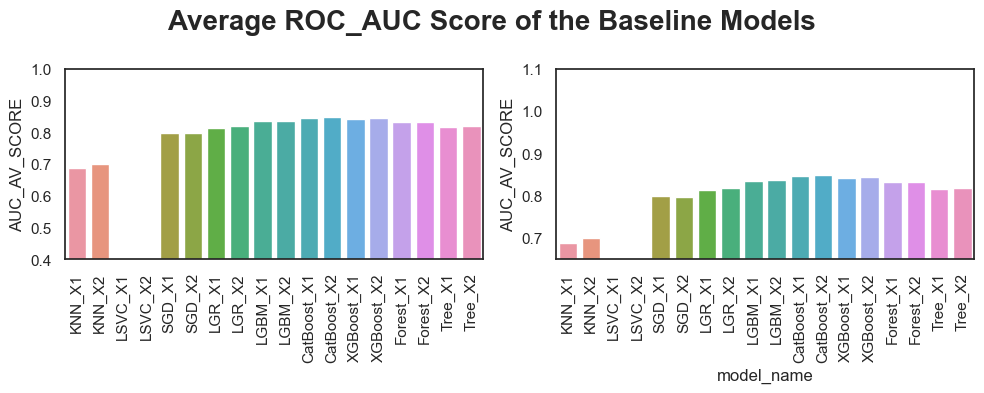

In [15]:
models_df.reset_index(inplace=True)
models_df.reset_index
sns.set(style='white', color_codes=True)
labels = list(models_df['model_name'].values)
ticks = models_df.index

fig, axes= plt.subplots(1,2, figsize=(10,4))

sns.barplot(x=ticks,y='AUC_AV_SCORE', data=models_df, ax=axes[0])
axes[0].set_xticks(ticks=ticks, labels=labels, rotation=90)
axes[0].set_ylim([.4, 1.0])
plt.xticks(rotation=90)

sns.barplot(x='model_name',y='AUC_AV_SCORE', data=models_df, ax=axes[1])
axes[1].set_ylim([.65, 1.1])
plt.xticks(rotation=90)

fig.suptitle("Average ROC_AUC Score of the Baseline Models", weight='bold', fontsize=20)
save_fig('KFold ROC_AUC Score of the Baseline Models', tight_layout=True);

 Figure 'KFold F1_Scores of the Baseline Models' Saved.


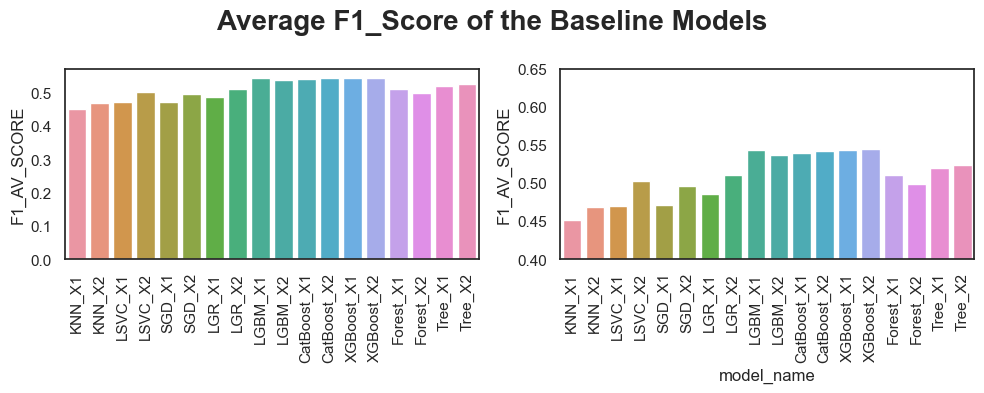

In [16]:
sns.set(style='white', color_codes=True)
labels = list(models_df['model_name'].values)
ticks = models_df.index

fig, axes= plt.subplots(1,2, figsize=(10,4))

sns.barplot(x=ticks,y='F1_AV_SCORE', data=models_df, ax=axes[0])
axes[0].set_xticks(ticks=ticks, labels=labels, rotation=90)
plt.xticks(rotation=90)

sns.barplot(x='model_name',y='F1_AV_SCORE', data=models_df, ax=axes[1])
axes[1].set_ylim([.40, .65])
axes[1].set_xticks(rotation=90, ticks=ticks, labels=labels)



fig.suptitle("Average F1_Score of the Baseline Models", weight='bold', fontsize=20)
save_fig('KFold F1_Scores of the Baseline Models', tight_layout=True);

 Figure 'KFold Precision Score of the Baseline Models' Saved.


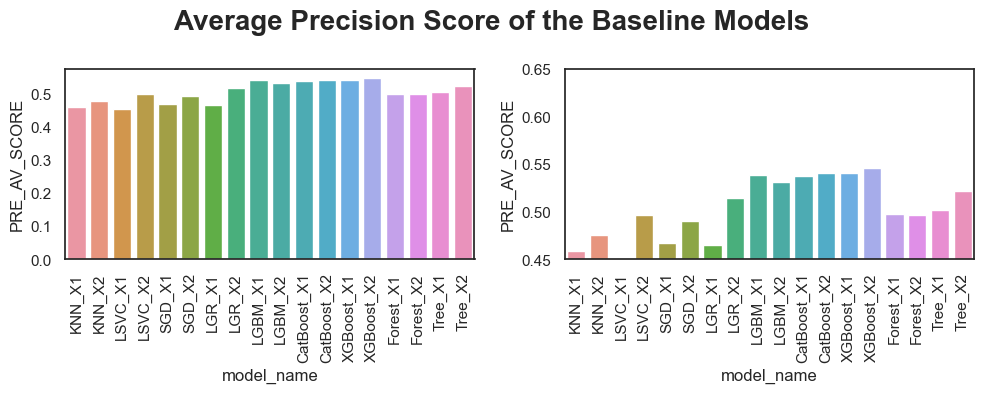

In [17]:
sns.set(style='white', color_codes=True)
labels = list(models_df['model_name'].values)
ticks = models_df.index

fig, axes= plt.subplots(1,2, figsize=(10,4))

sns.barplot(x='model_name',y='PRE_AV_SCORE', data=models_df, ax=axes[0])
axes[0].set_xticks(ticks=ticks, labels=labels, rotation=90)
plt.xticks(rotation=90)

sns.barplot(x='model_name',y='PRE_AV_SCORE', data=models_df, ax=axes[1])
axes[1].set_ylim([.45, .65])
axes[1].set_xticks(rotation=90, ticks=ticks, labels=labels)

fig.suptitle("Average Precision Score of the Baseline Models", weight='bold', fontsize=20)
save_fig('KFold Precision Score of the Baseline Models', tight_layout=True);

 Figure 'KFold Recall Score of the Baseline Models' Saved.


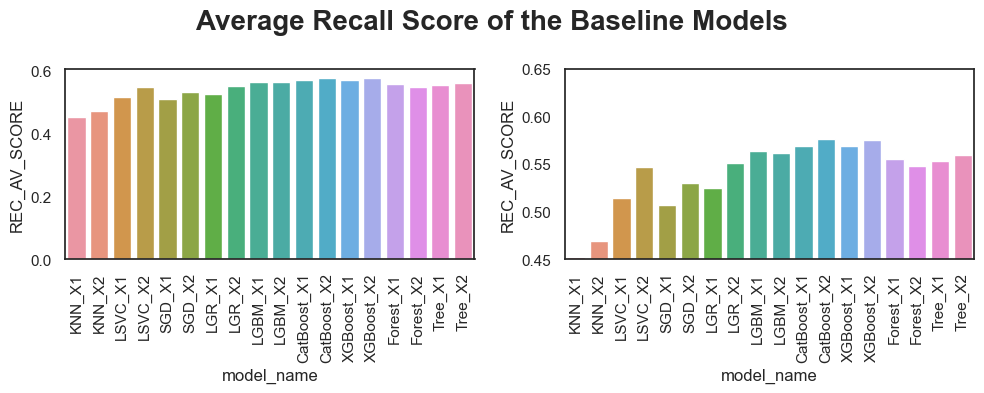

In [18]:
sns.set(style='white', color_codes=True)
labels = list(models_df['model_name'].values)
ticks = models_df.index

fig, axes= plt.subplots(1,2, figsize=(10,4))

sns.barplot(x='model_name',y='REC_AV_SCORE', data=models_df, ax=axes[0])
axes[0].set_xticks(ticks=ticks, labels=labels, rotation=90)
plt.xticks(rotation=90)

sns.barplot(x='model_name',y='REC_AV_SCORE', data=models_df, ax=axes[1])
axes[1].set_ylim([.45, .65])
axes[1].set_xticks(rotation=90, ticks=ticks, labels=labels)

fig.suptitle("Average Recall Score of the Baseline Models", weight='bold', fontsize=20)
save_fig('KFold Recall Score of the Baseline Models');